<a href="https://colab.research.google.com/github/zazzooo/project_geocoding/blob/main/remote_sensing_official.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### *Deep Learning E1394 - Problem Set 2 (w/ Solutions)*

# Remote Sensing - Land Use and Land Cover Classification using Pytorch


# Table of Contents


*   [Overview](#overview)
*   [Climate Impact](#climate-impact)
*   [Dependency Management](#dependency-management)
*   [Data Description](#data-description)
*   [Generate Train and Test Sets](#generate-train-and-test-sets)
*   [Visualize & Explore Data](#visualize--explore-data)
*   [Model Development](#model-development)
*   [Model Prediction](#model-prediction)
*   [Further Model Improvements](#further-model-improvements)
*   [References](#references)
*   [Credits](#credits)

### Housekeeping & submission

To utilize GPU support for model training, we highly recommend to open this notebook with Google Colab. Simply, change the domain from 'github.com' to 'githubtocolab.com' and refresh the site to open the notebook in Colab.

If you haven't used Colab before with private repositories, make sure to grant Colab access to your private repositories (see screenshot) and after that just try to change the domain again.

Make sure that you **always commit and push the changes you make in Colab back to GitHub**. To do so from within a Colab notebook, click `File` → `Save a copy in GitHub`. You will be prompted to add a commit message, and after you click OK, the notebook will be pushed to your repository. Only changes that are visible in your GitHub repository on the `main` branch will be considered for grading. If you close Colab in your browser without pushing your changes to GitHub or saving them on Google Drive, they will be lost.

Once the deadline has passed, you are not able to push to your repository anymore. In other words, there is no `submit` button which you need to press. You just need to ensure that all your work has been pushed to GitHub before the deadline.

<center>
<img src="https://github.com/hertie-data-science-lab/problem-set-2-groupf_thebest/blob/main/authorize-colab.png?raw=1" width="700" alt="GitHub Colab Authorization" class="center">
</center>



<a name="overview"></a>
# Overview
This tutorial covers an introduction to image classification using Pytorch for land use and land cover (LULC) mapping. 

Specifically, you will learn how to:
- classify satellite images into 10 LULC categories using the [EuroSAT dataset](https://arxiv.org/abs/1709.00029)
- fine-tune a Resnet-50 CNN model for image classification
- save and load trained models in Pytorch

 


<a name="climate-impact"></a>
# Climate Impact
A [report](https://www.wri.org/insights/7-things-know-about-ipccs-special-report-climate-change-and-land) by the World Resources Institute (WRI) states that about 23% of global human-caused GHG emissions come from land uses such as agriculture, forestry, and urban expansion. Land use change such as deforestation and land degradation are among the primary drivers of these emissions. Rapid urbanization leading to an increase in built-up areas as well as a massive loss of terrestrial carbon storage can also result in large carbon emissions.

Mapping the extent of land use and land cover categories over time is essential for better environmental monitoring, urban planning and nature protection. For example, monitoring changes in forest cover and identifying drivers of forest loss can be useful for forest conservation and restoration efforts. Assessing the vulnerability of certain land cover types, such as settlements and agricultural land, to certain risks can also be useful for for disaster risk reduction planning as well as long-term climate adaptation efforts. 

With the increasing availability of earth observation (EO) data coupled with recent advanced in computer vision, ML & EO has paved the way for the potential to map land use and land cover at an unprecedented scale. In this tutorial, we will explore the use of Sentinel-2 satellite images and deep learning models in Pytorch to automate LULC mapping.

<br>
<center><p><p> <img src="https://ptes.org/wp-content/uploads/2018/04/iStock-664630460-e1524839082464.jpg" alt="alt" width="50%"/>




# Dependency Management

This notebook requires Python >= 3.7. The following libraries are required:
*   tqdm
*   pandas
*   numpy
*   matplotlib
*   pytorch

In [ ]:
!pip install tdqm pandas numpy matplotlib torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## GPU Support
Before we start, you will need access to a GPU.  Fortunately, Google Colab provides free access to computing resources including GPUs. The GPUs currently available in Colab include Nvidia K80s, T4s, P4s and P100s. Unfortunately, there is no way to choose what type of GPU you can connect to in Colab. [See here for information](https://research.google.com/colaboratory/faq.html#gpu-availability).

To enable GPU in Google Colab:
1. Navigate to Edit→Notebook Settings or Runtime→Change Runtime Type.
2. Select GPU from the Hardware Accelerator drop-down.

In [1]:
# Standard libraries
import os
import random
from pathlib import Path
from tqdm.notebook import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

# Deep Learning libraries
import torch
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

Check that the GPU  enabled in your colab notebook by running the cell below.

In [2]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


<a name="data-description"></a>
# Data Description

In this section, you will learn how to:
- Download the EuroSAT dataset into your Google Drive
- Generate the train and test sets by splitting the EuroSAT dataset
- Visualize a sample of the images and their LULC labels

## EuroSAT Dataset
The [EuroSAT dataset](https://github.com/phelber/EuroSAT) contains 27,000 labelled 64x64 pixel Sentinel-2 satellite image patches with 10 different LULC categories. Both RGB and multi-spectral (MS) images are available for download. For simplicity, we will focus on RGB image classification. 

In [4]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip
!unzip -q EuroSAT.zip -d 'EuroSAT/'
!rm EuroSAT.zipAA

--2022-10-13 12:06:36--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  19.7MB/s    in 4.6s    

2022-10-13 12:06:41 (19.7 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]

rm: cannot remove 'EuroSAT.zipAA': No such file or directory


### Data Augmentation

Data augmentation is a  technique that randomly applies image transformations, e.g. crops, horizontal flips, and vertical flips, to the input images during model training. These perturbations reduce the neural network's overfitting to the training dataset, and they allow it to generalize better to the unseen test dataset.
<br><br>
<center> <img src="https://www.researchgate.net/publication/319413978/figure/fig2/AS:533727585333249@1504261980375/Data-augmentation-using-semantic-preserving-transformation-for-SBIR.png" width="400"/> 
</center>
<br>
<font size=2>Image Source: Ahmad, Jamil & Muhammad, Khan & Baik, Sung. (2017). Data augmentation-assisted deep learning of hand-drawn partially colored sketches for visual search. PLOS ONE. 12. e0183838. 10.1371/journal.pone.0183838. </font>
<br>


### Image Normalization
Additionally, in the cell below, the `transforms.Normalize` method normalizes each of the three channels to the given means and standard deviations defined in the `imagenet_mean` and `imagenet_std` variables. ImageNet is a large training dataset of images and labels.  Later in this tutorial, we will be using a model pre-trained on this dataset.  In order to use this pre-trained model for our LULC dataset, we need to ensure that the input dataset is normalized to have the same statistics (mean and standard deviation) as ImageNet. 

<br>
<center> <img src="https://cv.gluon.ai/_images/imagenet_banner.jpeg" width="400"/> 
<br>
<font size=2>Image Source: https://cv.gluon.ai/build/examples_datasets/imagenet.html </font>
<br>
</center>

Existing research has found that using models pretrained on massive datasets, such as ImageNet, improves accuracy when applying these neural networks to new datasets.  Pre-trained models serve as excellent generic feature extractors.  [Please read here for more information](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html).

In [5]:
input_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

### Load EuroSAT Dataset
Let's start by loading the EuroSAT dataset using torch's `ImageFolder` class.

`ImageFolder` is a generic data loader where the images are arranged in this way: 

```
    data
    └───AnnualCrop
    │   │   AnnualCrop_1.jpg
    │   │   AnnualCrop_2.jpg
    │   │   AnnualCrop_3.jpg
    │   │   ...
    └───Forest
    │   │   Forest_1.jpg
    │   │   Forest_2.jpg
    │   │   Forest_3.jpg
    │   │   ...
```


In [6]:
# Load the dataset
data_dir = os.path.join('EuroSAT', '2750')
dataset = datasets.ImageFolder(data_dir)

# Get LULC categories
class_names = dataset.classes
print("Class names: {}".format(class_names))
print("Total number of classes: {}".format(len(class_names)))

Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


## Generate Train and Test Sets


### Create Custom Dataset Class
In Pytorch, the `Dataset` class allows you to define a custom class to load the input and target for a dataset.  We will use this capability to load in our inputs in the form of RGB satellite images along with their corresponding labels.

In [49]:
class EuroSAT(data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        # Apply image transformations 
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        # Get class label
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)

### Split into Train and Test Sets
Here, we split the dataset into a train set and test set. The training set will be 80% of the Eurosat dataset, randomly selected. The remaining 20% of the dataset will be our test set.

In [8]:
# Apply different transformations to the training and test sets
train_data = EuroSAT(dataset, train_transform)
test_data = EuroSAT(dataset, test_transform)

# Randomly split the dataset into 80% train / 20% test 
# by subsetting the transformed train and test datasets
train_size = 0.8
indices = list(range(int(len(dataset))))
split = int(train_size * len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:split])
test_data = data.Subset(test_data, indices=indices[split:])
print("Train/test sizes: {}/{}".format(len(train_data), len(test_data)))

Train/test sizes: 21600/5400


In [ ]:
# Decreasing the number of sample for debugging

evens = list(range(0, len(train_data), 4))
evens_test = list(range(0, len(test_data),4))
#odds = list(range(1, len(trainset), 2))
trainset_1 = torch.utils.data.Subset(train_data, evens)

testset_1 = torch.utils.data.Subset(test_data, evens_test)
#trainset_2 = torch.utils.data.Subset(trainset, odds)

Finally, we use `torch`'s `DataLoader` class to create a dataloader.  The dataloader manages fetching samples from the datasets (it can even fetch them in parallel using `num_workers`) and assembles batches of the datasets. 

In [9]:
train_set = torch.utils.data.Subset(train_data, range(2400))
test_set = torch.utils.data.Subset(test_data, range(600))

In [22]:
num_workers = 2
batch_size = 16

train_loader = data.DataLoader(
    train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
test_loader = data.DataLoader(
    test_set, batch_size=batch_size, num_workers=num_workers, shuffle=True
)

In [ ]:
trainloader_1 = data.DataLoader(
    trainset_1, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
testloader_1 = data.DataLoader(
    testset_1, batch_size=batch_size, num_workers=num_workers, shuffle=True
)

## Visualize & Explore Data

In the cell below, we will visualize a batch of the dataset.  The cell visualizes the input to the neural network (the RGB image) along with the associated label.

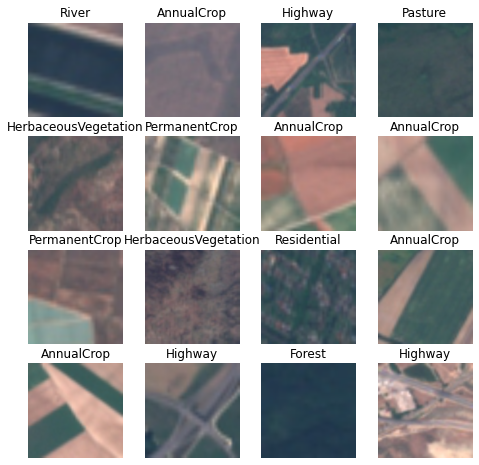

In [ ]:
n = 4
inputs, classes = next(iter(train_loader))
fig, axes = plt.subplots(n, n, figsize=(8,8))

for i in range(n):
  for j in range(n):
    image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)
   
    title = class_names[classes[i * n + j]]
    axes[i, j].imshow(image)
    axes[i, j].set_title(title)
    axes[i, j].axis('off')

Next, let's explore our dataset a little bit more. In particular, how many images of each class are included?

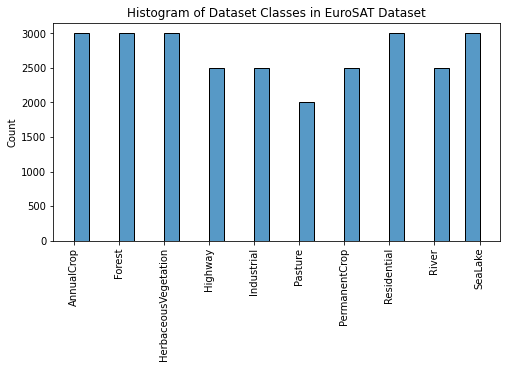

In [ ]:
plt.figure(figsize=(8, 4))
hist = sns.histplot(dataset.targets)

hist.set_xticks(range(len(dataset.classes)))
hist.set_xticklabels(dataset.classes, rotation=90)
hist.set_title('Histogram of Dataset Classes in EuroSAT Dataset')

plt.show()

# Model Development

## Model Selection: Transfer Learning using ResNet-50

To avoid having to train a deep CNN from scratch, we will utilize a network pretrained on another image classification problem to initialize our weights. We choose ResNet50, a popular neural network architecture, since [Helber et al.](https://arxiv.org/pdf/1709.00029.pdf) have shown that ResNet-50 works well for LULC classification on the EuroSAT. ResNet-50 has more than 23 million trainable parameters, which would be computationally infeasible for us to train from scratch.

<b>Recall</b>: Deep neural networks are difficult to train due to the problem of vanishing or exploding gradients (repeated multiplication making the gradient infinitively small). ResNet solves this by using shortcut connections that connect activation from an earlier layer to a further layer by skipping one or more layers as shown below. This allows for gradients to propagate to the deeper layers before they can be reduced to small or zero values.
<br><br>

<center> <img src="https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/images/resnet50.png" width="600"/><br>
Image source: <a href="https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/">https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/  </a>
</center>
<br>


In [11]:
# Specify which pretrained weights we want to use
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Specify how the final fully-connected layer should look like (number of output neurons should correspond to number of classes)
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))

model = model.to(device)
#torchsummary.summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Model Training and Evaluation

We can now proceed to model training and evaluation.

This section has three major parts:

1. Specify the criterion, optimizer, and hyperparameters (e.g. n_epochs, learning rate, etc.).
2. Train the model on the training set by updating its weights to minimize the loss function.
3. Evaluate the model on the test set to observe performance on new, unseen data.
4. Repeat steps 2 and 3 `n_epochs` times.

Let's start by creating our train function.

In [12]:
lr = 0.001 # try also 1e-3
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [23]:
def train(model, dataloader, criterion, optimizer, data_GPU_converter = 'to(device)'):
  model.train()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    if data_GPU_converter == 'to(device)':
      inputs = inputs.to(device)
      labels = labels.to(device)
    elif data_GPU_converter == 'torch.cuda.FloatTensor':
      inputs.type(torch.cuda.FloatTensor) 
      labels.type(torch.cuda.FloatTensor)
    else:
      raise ValueError('The variable \'data_GPU_converter\' takes one of this two value: [\'to(device)\' ,  \'torch.cuda.FloatTensor\']. Choose one of the two!')
    
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Compute the loss
    loss = criterion(outputs, labels)

    # Compute the gradients wrt the loss
    loss.backward()

    # Update the weights
    optimizer.step()

    _, preds = torch.max(outputs, 1)

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print("Train Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

In [24]:
train(model, train_loader, criterion=criterion, optimizer= optimizer)

  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 2.31; Accuracy: 10.62


(2.311258150736491, tensor(10.6250, device='cuda:0'))

Next, let's define the model evaluation function.

In [25]:
def evaluate(model, dataloader, criterion, data_GPU_converter = 'to(device)'):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    if data_GPU_converter == 'to(device)':
      inputs = inputs.to(device)
      labels = labels.to(device)
    elif data_GPU_converter == 'torch.cuda.FloatTensor':
      inputs.type(torch.cuda.FloatTensor) 
      labels.type(torch.cuda.FloatTensor)
    else:
      raise ValueError('The variable \'data_GPU_converter\' takes one of this two value: [\'to(device)\' ,  \'torch.cuda.FloatTensor\']. Choose one of the two!')
    #inputs = inputs.to(device)
    #labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels) 
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print("Test Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

We want to pass the entire training dataset multiple (`n_epochs`) times through the network, to minimize the cost as much as possible.

In [32]:
def fit(model, train_loader, val_loader, n_epochs, lr, early_stopping=False, early_stopping_patience=0, data_GPU_converter = 'to(device)'):
 
  # Specify criterion and optimizer
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  if early_stopping: # no need of this variable if early stopping is not necessary
    last_val_loss = 100 # made up value to inizialize the variable, it is usually below 1
    trigger_times = 0

  # Train and validation over n_epochs
  for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}')

    train(model, train_loader, criterion, optimizer, data_GPU_converter = data_GPU_converter)

    # Enter the loop if the early_stopping is set to True
    if early_stopping:
      print(f'Trigger time is: {trigger_times}')
      
      val_loss, _ = evaluate(model, val_loader, criterion, data_GPU_converter = data_GPU_converter) # add val_loss on the left only if you need it for the early stopping

      print(f'The validation loss is {val_loss:.3f}')

      if val_loss > last_val_loss:
        print(f'The validation loss ({val_loss:.3f}) is bigger than the one before ({last_val_loss:.3f}).\n Increasing trigger time.')
        trigger_times += 1
      else:
        print(f'The validation loss ({val_loss:.3f}) is smaller than the one before ({last_val_loss:.3f}).\n Setting trigger time to zero.')
        last_val_loss = val_loss
        trigger_times = 0
      if trigger_times >= early_stopping_patience:
        print(f'The validation set loss increased for {early_stopping_patience} times in a row. \n According to early stopping tecnique, it is better to stop the training to avoid overfitting!')
        return model, val_loss

  val_loss = evaluate(model, val_loader, criterion, data_GPU_converter = data_GPU_converter)
  return model, val_loss


Decide on a set of hyperparameters and train the network accordingly.

In [33]:
# Specify hyperparameters
n_epochs = 100
lr = 1e-3

# Train and return best model
best_model,_ = fit(model, train_loader, test_loader, n_epochs, lr, early_stopping=True, early_stopping_patience=3) 

## Remark: in theory we should rather perform the hyperparameter tuning on the validation set, which however we don't have

Epoch 1


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 2.23; Accuracy: 23.71
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 2.23; Accuracy: 23.33
The validation loss is 2.233
The validation loss (2.233) is smaller than the one before (100.000).
 Setting trigger time to zero.
Epoch 2


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 2.08; Accuracy: 42.58
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 2.05; Accuracy: 45.17
The validation loss is 2.054
The validation loss (2.054) is smaller than the one before (2.233).
 Setting trigger time to zero.
Epoch 3


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 1.93; Accuracy: 47.42
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 1.88; Accuracy: 55.50
The validation loss is 1.878
The validation loss (1.878) is smaller than the one before (2.054).
 Setting trigger time to zero.
Epoch 4


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 1.78; Accuracy: 54.42
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 1.76; Accuracy: 58.17
The validation loss is 1.759
The validation loss (1.759) is smaller than the one before (1.878).
 Setting trigger time to zero.
Epoch 5


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 1.63; Accuracy: 57.75
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 1.60; Accuracy: 65.00
The validation loss is 1.604
The validation loss (1.604) is smaller than the one before (1.759).
 Setting trigger time to zero.
Epoch 6


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 1.50; Accuracy: 60.08
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 1.45; Accuracy: 67.83
The validation loss is 1.446
The validation loss (1.446) is smaller than the one before (1.604).
 Setting trigger time to zero.
Epoch 7


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 1.37; Accuracy: 63.13
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 1.32; Accuracy: 68.33
The validation loss is 1.321
The validation loss (1.321) is smaller than the one before (1.446).
 Setting trigger time to zero.
Epoch 8


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 1.26; Accuracy: 64.62
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 1.18; Accuracy: 70.67
The validation loss is 1.176
The validation loss (1.176) is smaller than the one before (1.321).
 Setting trigger time to zero.
Epoch 9


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 1.14; Accuracy: 68.71
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 1.18; Accuracy: 69.50
The validation loss is 1.178
The validation loss (1.178) is bigger than the one before (1.176).
 Increasing trigger time.
Epoch 10


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 1.07; Accuracy: 70.58
Trigger time is: 1


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.98; Accuracy: 74.17
The validation loss is 0.984
The validation loss (0.984) is smaller than the one before (1.176).
 Setting trigger time to zero.
Epoch 11


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.99; Accuracy: 72.12
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.91; Accuracy: 76.67
The validation loss is 0.907
The validation loss (0.907) is smaller than the one before (0.984).
 Setting trigger time to zero.
Epoch 12


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.97; Accuracy: 72.08
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.84; Accuracy: 78.17
The validation loss is 0.838
The validation loss (0.838) is smaller than the one before (0.907).
 Setting trigger time to zero.
Epoch 13


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.89; Accuracy: 73.92
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.74; Accuracy: 82.33
The validation loss is 0.739
The validation loss (0.739) is smaller than the one before (0.838).
 Setting trigger time to zero.
Epoch 14


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.86; Accuracy: 73.96
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.69; Accuracy: 82.67
The validation loss is 0.691
The validation loss (0.691) is smaller than the one before (0.739).
 Setting trigger time to zero.
Epoch 15


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.78; Accuracy: 76.92
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.65; Accuracy: 82.83
The validation loss is 0.654
The validation loss (0.654) is smaller than the one before (0.691).
 Setting trigger time to zero.
Epoch 16


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.80; Accuracy: 75.67
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.63; Accuracy: 84.17
The validation loss is 0.627
The validation loss (0.627) is smaller than the one before (0.654).
 Setting trigger time to zero.
Epoch 17


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.74; Accuracy: 76.33
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.57; Accuracy: 85.33
The validation loss is 0.565
The validation loss (0.565) is smaller than the one before (0.627).
 Setting trigger time to zero.
Epoch 18


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.72; Accuracy: 77.75
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.54; Accuracy: 86.67
The validation loss is 0.538
The validation loss (0.538) is smaller than the one before (0.565).
 Setting trigger time to zero.
Epoch 19


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.67; Accuracy: 79.88
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.53; Accuracy: 87.17
The validation loss is 0.527
The validation loss (0.527) is smaller than the one before (0.538).
 Setting trigger time to zero.
Epoch 20


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.68; Accuracy: 78.88
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.54; Accuracy: 85.50
The validation loss is 0.539
The validation loss (0.539) is bigger than the one before (0.527).
 Increasing trigger time.
Epoch 21


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.62; Accuracy: 80.21
Trigger time is: 1


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.47; Accuracy: 88.83
The validation loss is 0.466
The validation loss (0.466) is smaller than the one before (0.527).
 Setting trigger time to zero.
Epoch 22


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.64; Accuracy: 79.71
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.46; Accuracy: 86.83
The validation loss is 0.459
The validation loss (0.459) is smaller than the one before (0.466).
 Setting trigger time to zero.
Epoch 23


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.62; Accuracy: 79.83
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.46; Accuracy: 86.33
The validation loss is 0.456
The validation loss (0.456) is smaller than the one before (0.459).
 Setting trigger time to zero.
Epoch 24


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.60; Accuracy: 80.54
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.39; Accuracy: 89.83
The validation loss is 0.389
The validation loss (0.389) is smaller than the one before (0.456).
 Setting trigger time to zero.
Epoch 25


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.56; Accuracy: 82.96
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.41; Accuracy: 89.67
The validation loss is 0.408
The validation loss (0.408) is bigger than the one before (0.389).
 Increasing trigger time.
Epoch 26


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.54; Accuracy: 83.08
Trigger time is: 1


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.37; Accuracy: 90.33
The validation loss is 0.371
The validation loss (0.371) is smaller than the one before (0.389).
 Setting trigger time to zero.
Epoch 27


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.56; Accuracy: 81.96
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.36; Accuracy: 90.67
The validation loss is 0.363
The validation loss (0.363) is smaller than the one before (0.371).
 Setting trigger time to zero.
Epoch 28


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.54; Accuracy: 82.04
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.33; Accuracy: 90.83
The validation loss is 0.333
The validation loss (0.333) is smaller than the one before (0.363).
 Setting trigger time to zero.
Epoch 29


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.52; Accuracy: 82.12
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.44; Accuracy: 85.67
The validation loss is 0.444
The validation loss (0.444) is bigger than the one before (0.333).
 Increasing trigger time.
Epoch 30


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.51; Accuracy: 84.58
Trigger time is: 1


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.34; Accuracy: 91.17
The validation loss is 0.343
The validation loss (0.343) is bigger than the one before (0.333).
 Increasing trigger time.
Epoch 31


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.48; Accuracy: 84.33
Trigger time is: 2


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.31; Accuracy: 92.00
The validation loss is 0.314
The validation loss (0.314) is smaller than the one before (0.333).
 Setting trigger time to zero.
Epoch 32


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.49; Accuracy: 83.25
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.30; Accuracy: 91.17
The validation loss is 0.297
The validation loss (0.297) is smaller than the one before (0.314).
 Setting trigger time to zero.
Epoch 33


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.48; Accuracy: 84.00
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.28; Accuracy: 91.83
The validation loss is 0.279
The validation loss (0.279) is smaller than the one before (0.297).
 Setting trigger time to zero.
Epoch 34


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.48; Accuracy: 84.12
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.28; Accuracy: 91.50
The validation loss is 0.276
The validation loss (0.276) is smaller than the one before (0.279).
 Setting trigger time to zero.
Epoch 35


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.49; Accuracy: 83.54
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.26; Accuracy: 91.67
The validation loss is 0.264
The validation loss (0.264) is smaller than the one before (0.276).
 Setting trigger time to zero.
Epoch 36


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.47; Accuracy: 84.58
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.25; Accuracy: 93.50
The validation loss is 0.245
The validation loss (0.245) is smaller than the one before (0.264).
 Setting trigger time to zero.
Epoch 37


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.46; Accuracy: 85.08
Trigger time is: 0


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.25; Accuracy: 93.17
The validation loss is 0.250
The validation loss (0.250) is bigger than the one before (0.245).
 Increasing trigger time.
Epoch 38


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.45; Accuracy: 84.42
Trigger time is: 1


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.28; Accuracy: 91.50
The validation loss is 0.279
The validation loss (0.279) is bigger than the one before (0.245).
 Increasing trigger time.
Epoch 39


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.43; Accuracy: 85.42
Trigger time is: 2


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.32; Accuracy: 90.00
The validation loss is 0.316
The validation loss (0.316) is bigger than the one before (0.245).
 Increasing trigger time.
The validation set loss increased for 3 times in a row. 
 According to early stopping tecnique, it is better to stop the training to avoid overfitting!


## Persisting & Loading Model

Save the trained model to the file system:


In [34]:
model_dir = Path('models')
model_dir.mkdir(parents=True, exist_ok=True)
model_file = os.path.join(model_dir, 'best_model.pth')

torch.save(best_model, model_file)

print('Model successfully saved to {}'.format(model_file))

Model successfully saved to models/best_model.pth


Loading a previously trained model from the file system:

In [35]:
model = torch.load(model_file)

<a name="results-and-discussion"></a>
# Model Prediction

Let's visualize an example of the neural network making a prediction.

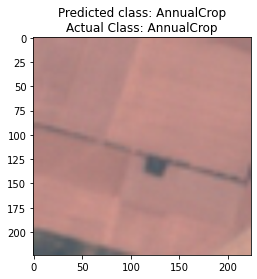

In [39]:
# Retrieve sample image
index = 1
image, label = test_data[index]
image = image.to(device)
# Predict on sample
output = model(image.unsqueeze(0))
_, pred = torch.max(output, 1)

# Get corresponding class label
label = class_names[label]
pred = class_names[pred[0]]

# Visualize sample and prediction
image = image.cpu().numpy().transpose((1, 2, 0))
image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(image)
ax.set_title("Predicted class: {}\nActual Class: {}".format(pred, label));

Here, we show how to run the model on a PIL image.

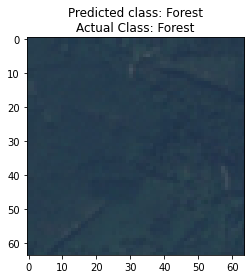

In [42]:
label = 'Forest'
image_path = os.path.join('EuroSAT', '2750', label, f'{label}_1.jpg')
image = Image.open(image_path)

# Transform image
input = test_transform(image)

input = input.to(device)


# Predict on sample
output = model(input.unsqueeze(0))

# Get corresponding class label
_, pred = torch.max(output, 1)
pred = class_names[pred[0]]

# Visualize results
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(image)
ax.set_title("Predicted class: {}\nActual Class: {}".format(pred, label));

# Further Model Improvements

### Model Selection: Trying Different CNN Architectures
 
Model and architecture selection are often an important part of the machine learning pipeline. Previously, we have just picked ResNet-50 because it was successfully utilized for the Eurosat LULC classification problem before. Now, let's investigate how different CNN architectures perform on the same problem. For PyTorch you can find more information on the different CNN classification architectures with pre-trained weights [here](https://pytorch.org/vision/0.8/models.html). 

For the future, keep in mind that we don't want to perform the final evaluation on the same data we used for model selection and tuning the architecture hyperparameters, to avoid data leakage and overoptimistic evaluation results. 

### Comment to TASK 4

The alternative model we chose is VGG16, a quite famous convolutional neural network that has been trained on a subset of the ImageNet dataset, a collection of over 14 million images belonging to 22,000 categories. Its architecture is quite suitable for detecting generic visual features, so that we can use its pretrained neurons for feature extraction and training on our LULC dataset.

The following image classification task is similar to the one for which VGG16 has been trained, and that's the reason why we decided on it. 

Citation:
Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.

In [46]:
'''
TODO: Task 4 - Train a model for the Eurosat LULC classification problem using a different CNN architecture with another set of pre-trained weights.

Briefly explain why you chose the particular architecture you did (around 2-3 sentences).
'''

import torchvision.models as models

vgg16 = models.vgg16() # VGG16 won the 1st and 2nd place at the localisation and classification tracks

n_epochs = 35
lr = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16.parameters(), lr=lr)

fit(vgg16, train_loader, test_loader, n_epochs, lr, early_stopping=True, early_stopping_patience=0, data_GPU_converter = 'torch.cuda.FloatTensor') # however on this dataset is very slow 


Epoch 1


  0%|          | 0/150 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### Transfer Learning: Trying Different Fine-tuning Strategies

Previously, we have intialized the network with weights from another image classification problem and updated all of them as we were training on the Eurosat LULC dataset. Another approach to fine-tuning uses the pretrained convolutional layers as a fixed feature extractor by freezing those weights and only updates the weights of the last, fully-connected layer(s) responsible for classification.

### Comment for TASK 5

Our first model ResNet50 ran for 39 epochs with an Accuracy of 90.00 with early stopping technique at patience = 3. 
As a second strategy, we decided to run the frozen ResNet_50 for 35 epochs only, and the result test accuracy equals to 91.67.
Since the results are quite similar, training the model from scratch doesn't influence the performance too much, as the weights are trained well enough to compute the task with an optimal performance. 

In [47]:
'''
TODO: Task 5 - Retrain and evaluate the network with frozen ResNet50_Weights for all, but the last layer.

Briefly elaborate on how the results of the two different strategies differ and why possibly (around 3-4 sentences).
'''

model_freeze = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

for param in model.parameters():
  param.requires_grad = False

# Specify how the final fully-connected layer should look like (number of output neurons should correspond to number of classes)
model_freeze.fc = torch.nn.Linear(model_freeze.fc.in_features, len(dataset.classes))

model_freeze = model_freeze.to(device)

n_epochs = 35

best_model_freeze, _ = fit(model_freeze, train_loader, test_loader, n_epochs, lr) 

Epoch 1


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 2.26; Accuracy: 17.12
Epoch 2


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 2.11; Accuracy: 40.42
Epoch 3


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 1.93; Accuracy: 50.54
Epoch 4


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 1.71; Accuracy: 55.38
Epoch 5


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 1.50; Accuracy: 60.25
Epoch 6


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 1.34; Accuracy: 63.00
Epoch 7


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 1.24; Accuracy: 64.71
Epoch 8


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 1.12; Accuracy: 67.58
Epoch 9


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 1.04; Accuracy: 68.38
Epoch 10


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 1.01; Accuracy: 69.67
Epoch 11


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.96; Accuracy: 71.04
Epoch 12


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.91; Accuracy: 71.83
Epoch 13


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.86; Accuracy: 72.71
Epoch 14


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.82; Accuracy: 74.21
Epoch 15


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.78; Accuracy: 76.54
Epoch 16


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.77; Accuracy: 76.12
Epoch 17


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.72; Accuracy: 77.50
Epoch 18


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.71; Accuracy: 77.46
Epoch 19


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.68; Accuracy: 78.17
Epoch 20


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.68; Accuracy: 77.96
Epoch 21


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.66; Accuracy: 77.12
Epoch 22


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.64; Accuracy: 78.12
Epoch 23


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.60; Accuracy: 81.50
Epoch 24


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.61; Accuracy: 80.33
Epoch 25


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.59; Accuracy: 80.96
Epoch 26


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.58; Accuracy: 82.12
Epoch 27


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.57; Accuracy: 81.71
Epoch 28


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.55; Accuracy: 82.04
Epoch 29


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.54; Accuracy: 82.67
Epoch 30


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.54; Accuracy: 81.29
Epoch 31


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.52; Accuracy: 82.75
Epoch 32


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.50; Accuracy: 83.54
Epoch 33


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.51; Accuracy: 83.17
Epoch 34


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.49; Accuracy: 84.38
Epoch 35


  0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.48; Accuracy: 84.50


  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.29; Accuracy: 91.67


In [50]:
evaluate(best_model_freeze, test_loader, criterion = criterion, data_GPU_converter = 'to(device)')

  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.29; Accuracy: 91.67


(0.2890949924786886, tensor(91.6667, device='cuda:0'))

### Hyperparameter Tuning: Systematically Trying Different Hyperparameters



In [ ]:
# !pip install ray
# !pip install -U tensorboardx

In [ ]:
from ray import tune

def run_model(config):
  lr = config['lr']
  # n_epochs = config['n_epochs']

  trainloader_1 = data.DataLoader(
    trainset_1, batch_size=batch_size, num_workers=1, shuffle=True)
  testloader_1 = data.DataLoader(
    testset_1, batch_size=batch_size, num_workers=1, shuffle=True)

  model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

  # Specify how the final fully-connected layer should look like (number of output neurons should correspond to number of classes)
  model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))

  model = model.to(device)
  
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  
  for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}')

    train(model, train_loader, criterion, optimizer)
  
  loss , acc = evaluate(model, val_loader, criterion)
    
  tune.report(loss = loss)

result = tune.run(run_model, 
                  config = {'lr' : tune.uniform(1e-3,1e-1)})


#tune.report(mean_accuracy=acc)



In [ ]:
# Lukas version 

from ray import tune

def train_fun(…):
  current_loss = model.train()
  tune.report(loss = current_loss())

tune.run(
    train_fun,
    config={"alpha": tune.uniform(0.001, 0.1)},
    num_samples=100,
    scheduler="asha",
    search_alg="optuna"
)

In [ ]:
config = {'lr' : 1e-1,
        'n_epochs': tune.choice([2, 4, 8, 16])
          }

run_model(config)

TypeError: ignored

In [48]:
'''
TODO: Task 6 - Implement a systematic hyperparameter tuning using grid or random search for at least 5 different hyperparameter combinations of at least 2 different hyperparameters.

Report which hyperparameters performed best and briefly elaborate why you believe this is the case (around 2-3 sentences).

Notes:
* you may use any Python library of your choice to facilitate the hyperparameter tuning
* you may freely chose which hyperparameters you want to optimize, but keep in mind that some have significant impact on the training time
'''

def grid_search(model, config):
  d = {}
  n_epochs = 20
  for learning_rate in range(len(config['lr'])):
    for patience in range(len(config['early_stopping_patience'])):
      _, val_loss = fit(model, trainloader_1, testloader_1, n_epochs = n_epochs, lr = learning_rate, early_stopping=True, early_stopping_patience=patience)
      d['lr: ' + str(learning_rate) + ' E.S. patience: ' + str(patience)] = val_loss
  return d 
  

In [ ]:
config = {'lr' : [1e-1, 1e-2, 1e-3],
        'early_stopping': [1,2,3]}

grid_search(model, config)

  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 2.33; Accuracy: 5.78
Epoch 1


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 2.33; Accuracy: 8.17


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 2.34; Accuracy: 7.63
Epoch 1


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 2.33; Accuracy: 8.54
Epoch 2


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 2.33; Accuracy: 8.52


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 2.34; Accuracy: 7.33
Epoch 1


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 2.33; Accuracy: 7.67
Epoch 2


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 2.33; Accuracy: 8.50
Epoch 3


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 2.33; Accuracy: 8.39


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 2.34; Accuracy: 7.56


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 2.34; Accuracy: 7.56
Epoch 1


  0%|          | 0/338 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### Training from Scratch

In order to explore how much the pre-training helped and which challenges it mitigated, let's train a CNN from scratch.

In [ ]:
'''
TODO: Task 7 - Train a convolutional neural network from scratch for the Eurosat LULC classification problem

Briefly elaborate on how well the network learns compared to previous transfer learning approaches (around 3-4 sentences).

Notes:
* use a Python library of your choice (e.g. Keras, PyTorch, etc.) 
* use a network architecture of your choice (not too deep, to keep it computationally feasible)
* no minimum requirement in terms of validation accuracy (though at least 3 epochs with overall visible accuracy improvement)
'''

import torch.nn.functional as F
import torch.nn as nn


# Creating a CNN class

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = Net()

lr = 0.001 
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

best_model_scratch, _ = fit(model, train_loader, criterion=criterion, optimizer= optimizer, data_GPU_converter= 'torch.cuda.FloatTensor')

  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 2.27; Accuracy: 18.00


(2.2721378824445937, tensor(18.))

### Comment on TASK 7:


### Binary classification

For some applications, the granularity of land cover classes may not be necessary, and only whether the land is built-up/sealed or natural is of interest.

As a reminder, these are the land cover classes of the EuroSAT dataset:
```
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
```

In [ ]:
'''
TODO: Task 8 - Develop an approach to efficiently classify satellite imagery into built-up and natural areas.

Please elaborate why you chose the approach and why you believe it works better than other approaches (e.g. binary classification vs. multiclass classification with postprocessing) (around 5-8 sentences)
'''

from distutils.dir_util import copy_tree

# Generate new image folder structure for binary classification
os.makedirs('EuroSAT/2750_binary', exist_ok=True)

# copy images in new folder for binary classification
for folder in os.listdir(data_dir): 
  # built-up/sealed
  if folder in ['Highway', 'Industrial', 'Pasture', 'Residential']:
    copy_tree(
        "EuroSAT/2750/" + folder,
        "EuroSAT/2750_binary/BuiltUpSealed"
    )
  # natural
  elif folder in ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'PermanentCrop', 'River', 'SeaLake']:
    copy_tree(
        "EuroSAT/2750/" + folder,
        "EuroSAT/2750_binary/Natural"
    )

data_dir_binary = os.path.join('EuroSAT', '2750_binary')
dataset_binary = datasets.ImageFolder(data_dir_binary)
print(dataset_binary)

Dataset ImageFolder
    Number of datapoints: 27000
    Root location: EuroSAT/2750_binary


In [ ]:
# Get LULC categories (binary classification)
class_names_binary = dataset_binary.classes
print("Class names: {}".format(class_names_binary))
print("Total number of classes: {}".format(len(class_names_binary)))

Class names: ['BuiltUpSealed', 'Natural']
Total number of classes: 2


#### Split into Train and Test Sets for binary classification
Here, we split the dataset into a train set and test set. The training set will be 80% of the Eurosat dataset, randomly selected. The remaining 20% of the dataset will be our test set. This follows the same scheme as applied in multiclass classification.

In [ ]:
# Apply different transformations to the training and test sets
train_data_binary = EuroSAT(dataset_binary, train_transform)
test_data_binary = EuroSAT(dataset_binary, test_transform)

# Randomly split the dataset into 80% train / 20% test 
# by subsetting the transformed train and test datasets
train_size = 0.8
indices = list(range(int(len(dataset_binary))))
split = int(train_size * len(dataset_binary))
np.random.shuffle(indices)

train_data_binary = data.Subset(train_data_binary, indices=indices[:split])
test_data_binary = data.Subset(test_data_binary, indices=indices[split:])
print("Train/test sizes: {}/{}".format(len(train_data_binary), len(test_data_binary)))

Train/test sizes: 21600/5400


Finally, we use `torch`'s `DataLoader` class to create a dataloader.  The dataloader manages fetching samples from the datasets (it can even fetch them in parallel using `num_workers`) and assembles batches of the datasets. 

In [ ]:
num_workers = 2
batch_size = 16

train_loader_binary = data.DataLoader(
    train_data_binary, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
test_loader_binary = data.DataLoader(
    test_data_binary, batch_size=batch_size, num_workers=num_workers, shuffle=True
)

In [ ]:
# Specify which pretrained weights we want to use
model_binary = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Specify how the final fully-connected layer should look like (number of output neurons should correspond to number of classes - 2 in binary case, 10 in multiclass case)
print(f"Number of classes for multiclass model: {len(dataset.classes)}")
print(f"Number of classes for binary model: {len(dataset_binary.classes)} (obviously)\n\n")
model_binary.fc = torch.nn.Linear(model_binary.fc.in_features, len(dataset_binary.classes))
print(model_binary.fc)

CUDA_LAUNCH_BLOCKING=1
model_binary = model_binary.to(device)
torchsummary.summary(model_binary, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Number of classes for multiclass model: 10
Number of classes for binary model: 2 (obviously)


Linear(in_features=2048, out_features=2, bias=True)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12

If we compare the model specification of the binary model with the multiclass (10 target classes) we see that there we just changed the final linear (output) layer of the model. Hence, the number of parameters and size of the model is basically the same, the final layer just has 2 classes instead of 10. Running the model thus won't take considerably less time.

In [ ]:
def train_binary(model, dataloader, criterion, optimizer, data_GPU_converter = 'to(device)'):
  model.train()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    if data_GPU_converter == 'to(device)':
      inputs = inputs.to(device)
      labels = labels.to(device)
    elif data_GPU_converter == 'torch.cuda.FloatTensor':
      inputs.type(torch.cuda.FloatTensor) 
      labels.type(torch.cuda.FloatTensor)
    else:
      raise ValueError('The variable \'data_GPU_converter\' takes one of this two value: [\'to(device)\' ,  \'torch.cuda.FloatTensor\']. Choose one of the two!')
   
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    outputs_shaped = outputs.view(-1,2)[:,0].float()
    labels_shaped = labels.view(-1).float()

    loss = criterion(outputs_shaped, labels_shaped)
    # Compute the gradients wrt the loss
    loss.backward()

    # Update the weights based on the 
    # internally stored gradients
    optimizer.step()
    _, preds = torch.max(outputs, 1, keepdim=False)

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print("Train Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

In [ ]:
lr = 0.001 # try also 1e-3
criterion_binary = torch.nn.CrossEntropyLoss()
optimizer_binary = torch.optim.SGD(model_binary.parameters(), lr=lr)

Next, let's define the model evaluation function.

In [ ]:
def evaluate_binary(model, dataloader, criterion):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)

      outputs_shaped = outputs.view(-1,2)[:,1].float()
      labels_shaped = labels.view(-1).float()

      loss = criterion(outputs_shaped, labels_shaped)
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print("Test Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

We want to pass the entire training dataset multiple (`n_epochs`) times through the network, to minimize the cost as much as possible.

In [ ]:
def fit_binary(model, train_loader, val_loader, n_epochs, lr, early_stopping=False, early_stopping_patience=0):
 
  # Specify criterion and optimizer
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  if early_stopping == True: # no need this variable if early stopping is not necessary
    last_val_loss = 1000 # made up value to inizialize the variable
    trigger_times = 0

  # Train and validation over n_epochs
  for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}')

    train_binary(model, train_loader, criterion, optimizer)

    # enter the loop if the early_stopping is set to True
    if early_stopping == True:
      print(f'Trigger time is: {trigger_times}')
      
      val_loss, _ = evaluate_binary(model, val_loader, criterion) # do this only if you need the val_loss for the early stopping

      if val_loss > last_val_loss:
        trigger_times += 1
      else:
        last_val_loss = val_loss
        trigger_times = 0
      if trigger_times >= early_stopping_patience:
        print(f'The validation set loss increased for  {early_stopping_patience} times in a row. Accorngly to early stopping tecnique, it is better to stop the training to avoid overfitting!')
        break


Decide on a set of hyperparameters and train the network accordingly.

In [ ]:
# Specify hyperparameters
n_epochs = 100 #100
lr = 1e-3

# Train and return best model
best_model_binary = fit_binary(
    model_binary, 
    train_loader_binary, 
    test_loader_binary, 
    n_epochs, 
    lr, 
    early_stopping=True,
    early_stopping_patience=4
 )

Epoch 1


  0%|          | 0/1350 [00:00<?, ?it/s]

#### Persisting & Loading Binary Model

Save the trained model to the file system:


In [ ]:
model_dir = Path('models')
model_dir.mkdir(parents=True, exist_ok=True)
model_file_binary = os.path.join(model_dir, 'best_model_binary.pth')

torch.save(best_model_binary, model_file_binary)

print('Model successfully saved to {}'.format(model_file_binary))

# References
- Helber, P., Bischke, B., Dengel, A., & Borth, D. (2019). Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 12(7), 2217-2226.

## Credits

Many thanks to original content creators of this tutorial Ankur Mahesh and Isabelle Tingzon!